In [1]:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
x = []
id = []
import os
import numpy as np
for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
    for filename in filenames:
#         print(dirname+filename)
        x.append(dirname+'/'+filename)
        id.append(filename[:-4])
# Any results you write to the current directory are saved as output.
del x[0:2]
del id[0:2]

import pandas as pd
y = pd.read_csv('/kaggle/input/datathonfinalround/labels.csv')
y.head()

trainlist = pd.DataFrame(id,columns=['id'])
trainlist['path'] = x
trainlist = trainlist.sort_values('id')
trainlist.set_index('id',inplace=True)
tr = trainlist.drop(trainlist.tail(20000).index)

trainlabel = y['Expected'][0:60001]
trainlabel.to_csv('/kaggle/working/trainlabel.csv',header = False)
tr.to_csv('/kaggle/working/trainpath.csv')

x_path = '/kaggle/working/trainpath.csv'
y_path = '/kaggle/working/trainlabel.csv'
x_file = pd.read_csv(x_path)
y_file = pd.read_csv(y_path)
x = x_file['path']
x = x[:60000]
y = y_file['1']

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:

print(x[59999])
print(y[59998])
print(len(x))
print(len(y))

/kaggle/input/datathonfinalround/train-images-5/Train-Images-5/060000.jpg
8
60000
60000


In [3]:
#df_label = pd.read_csv('/kaggle/input/datathonfinalround/labels.csv')
#m = df_label
#m = df_label['Expected']
#y = m[:10000]

In [4]:
df_submit = pd.read_csv('/kaggle/input/datathonfinalround/sampleSubmission.csv')
df_submit.shape

(4, 2)

****
input path: ../input/datathonfinalround/labels.csv

In [5]:
ls

__notebook_source__.ipynb  trainlabel.csv  trainpath.csv


In [6]:
import cv2
im = cv2.imread('/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000001.jpg')
im.shape
im2 = cv2.resize(im,(624,468))
im2.shape

(468, 624, 3)

**create model and try to train**

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [8]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
HEIGHT = 300
WIDTH = 300
NUM_CLASSES = 14

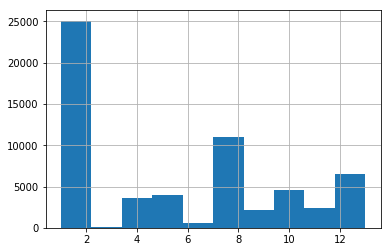

In [9]:
x, y = shuffle(x, y, random_state=8)
y.hist()

In [10]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(51000,)
(51000, 14)
(9000,)
(9000, 14)


In [11]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [12]:
x[1]

'/kaggle/input/datathonfinalround/train-images-1/Train-Images-1/000002.jpg'

In [13]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            #img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.imread(sample)
            img = cv2.resize(img, (WIDTH, HEIGHT))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            #img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.imread(sample)
            img = cv2.resize(img, (WIDTH, HEIGHT))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y


In [22]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights("/kaggle/input/densenetmodel/DenseNet-BC-121-32-no-top.h5")
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    return model

In [48]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 32
checkpoint = ModelCheckpoint('/kaggle/working/densenet_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='/kaggle/working/training_log.csv',
                       separator=',',
                       append=True)

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(HEIGHT,WIDTH,3), 
    n_out=NUM_CLASSES)

In [34]:
csv_logger = CSVLogger(filename='/kaggle/working/training_log.csv',
                       separator=',',
                       append=True)

In [24]:
#model.load_weights('/kaggle/working/densenet_bestqwk.h5')

In [25]:
cd ../input/densenetmodel/

[Errno 2] No such file or directory: '../input/densenetmodel/'
/kaggle/input/densenetmodel


In [26]:
# cd /kaggle/input/densenetmodel/DenseNet-BC-121-32-no-top.h5/

In [27]:
ls

DenseNet-BC-121-32-no-top.h5


In [28]:
ls

DenseNet-BC-121-32-no-top.h5


In [29]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[1,2,3,4,5,6,7,8,9,10,11,12,13],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            predict = np.sum(flatten(self.y_val)==flatten(y_pred))/len(flatten(y_pred))
            print(predict)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('/kaggle/working/densenet_bestqwk.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [30]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

Epoch 1/2
282/282 [==============================] - 107s 381ms/step

 epoch: 1 - QWK_score: 0.161486 

0.38322222222222224
saving checkpoint:  0.1614860580369346
Epoch 2/2
282/282 [==============================] - 91s 322ms/step

 epoch: 2 - QWK_score: 0.188301 

0.3781111111111111
saving checkpoint:  0.18830131639709802


In [49]:
epochs = 4;
# train all layers
for layer in model.layers:
    layer.trainable = True
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(loss='categorical_crossentropy',
            # loss=kappa_loss,
            optimizer=Adam(lr=1e-4))
model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/4
1594/1594 [==============================] - 2300s 1s/step - loss: 2.0587 - val_loss: 1.6178

Epoch 00001: val_loss improved from inf to 1.61776, saving model to /kaggle/working/densenet_.h5
282/282 [==============================] - 94s 332ms/step

 epoch: 1 - QWK_score: 0.458123 

0.48677777777777775
saving checkpoint:  0.4581225282608472
Epoch 2/4
1594/1594 [==============================] - 2215s 1s/step - loss: 1.7230 - val_loss: 1.5112

Epoch 00002: val_loss improved from 1.61776 to 1.51121, saving model to /kaggle/working/densenet_.h5
282/282 [==============================] - 83s 295ms/step

 epoch: 2 - QWK_score: 0.502759 

0.5441111111111111
saving checkpoint:  0.5027585124658998
Epoch 3/4
1594/1594 [==============================] - 2202s 1s/step - loss: 1.6196 - val_loss: 1.4180

Epoch 00003: val_loss improved from 1.51121 to 1.41803, saving model to /kaggle/working/densenet_.h5
282/282 [==============================] - 84s 298ms/step

 epoch: 3 - QWK_score: 0.50

In [51]:
submit = pd.read_csv('/kaggle/input/datathonfinalround/sampleSubmission.csv')
model.load_weights('/kaggle/working/densenet_bestqwk.h5')
predicted = []
id_test = []

In [ ]:
cd /kaggle/working

In [ ]:
ls

In [38]:

img_path =[]
for dirname, _, filenames in os.walk('/kaggle/input/datathonfinalround/test-images/Test-Images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        img_path.append(os.path.join(dirname, filename))
len(img_path)
img_path[0]

'/kaggle/input/datathonfinalround/test-images/Test-Images/107198.jpg'

In [52]:
for i in range(100001,120001):
    path = os.path.join('/kaggle/input/datathonfinalround/test-images/Test-Images/', str(i)+'.jpg')
    print(path)
    image = cv2.imread(path)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    X = np.array((image[np.newaxis])/255)
    score_predict=((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    label_predict = np.argmax(score_predict)
    print(label_predict)
    predicted.append(str(label_predict))
    id_test.append(str(i))
    

/kaggle/input/datathonfinalround/test-images/Test-Images/100001.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100002.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100003.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100004.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100005.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100006.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100007.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100008.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100009.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100010.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100011.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100012.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100013.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100014.jpg
4
/kaggle/input/datath

8
/kaggle/input/datathonfinalround/test-images/Test-Images/100119.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100120.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100121.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100122.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100123.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100124.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100125.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100126.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100127.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100128.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100129.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100130.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100131.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100132.jpg
8
/kaggle/input/data

2
/kaggle/input/datathonfinalround/test-images/Test-Images/100236.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100237.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100238.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100239.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100240.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100241.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100242.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100243.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100244.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100245.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100246.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100247.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100248.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100249.jpg
1
/kaggle/input/dat

10
/kaggle/input/datathonfinalround/test-images/Test-Images/100353.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100354.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/100355.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100356.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100357.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100358.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100359.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100360.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100361.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100362.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100363.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100364.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100365.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100366.jpg
2
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/100471.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100472.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100473.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100474.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100475.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100476.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100477.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100478.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100479.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100480.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100481.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100482.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100483.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100484.jpg
1
/kaggle/input/data

4
/kaggle/input/datathonfinalround/test-images/Test-Images/100589.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100590.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100591.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100592.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100593.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100594.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100595.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100596.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100597.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100598.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/100599.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100600.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100601.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/100602.jpg
1
/kaggle/i

5
/kaggle/input/datathonfinalround/test-images/Test-Images/100708.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100709.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100710.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100711.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100712.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100713.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100714.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100715.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100716.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100717.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100718.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100719.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100720.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100721.jpg
8
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/100827.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100828.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100829.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100830.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/100831.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/100832.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100833.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100834.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100835.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100836.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/100837.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100838.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100839.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100840.jpg
1
/kaggle/input/da

1
/kaggle/input/datathonfinalround/test-images/Test-Images/100946.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/100947.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100948.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/100949.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100950.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/100951.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100952.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100953.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100954.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100955.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100956.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/100957.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/100958.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/100959.jpg
9
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/101065.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101066.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101067.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101068.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101069.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101070.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101071.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101072.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101073.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101074.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101075.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/101076.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101077.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101078.jpg
1
/kaggle/in

8
/kaggle/input/datathonfinalround/test-images/Test-Images/101182.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/101183.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101184.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101185.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101186.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101187.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101188.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101189.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101190.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101191.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101192.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101193.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101194.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101195.jpg
8
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/101299.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101300.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101301.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101302.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101303.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101304.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/101305.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101306.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101307.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101308.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101309.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101310.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101311.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101312.jpg
12
/kaggle/input/dat

2
/kaggle/input/datathonfinalround/test-images/Test-Images/101416.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101417.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101418.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101419.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101420.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101421.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101422.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101423.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/101424.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101425.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101426.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101427.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101428.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/101429.jpg
2
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/101533.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/101534.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/101535.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101536.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101537.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101538.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101539.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101540.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101541.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101542.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/101543.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/101544.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/101545.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/101546.jpg
12
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/101651.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101652.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101653.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101654.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101655.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101656.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101657.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101658.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101659.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101660.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101661.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101662.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101663.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/101664.jpg
5
/kaggle/inpu

11
/kaggle/input/datathonfinalround/test-images/Test-Images/101768.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101769.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101770.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101771.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101772.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101773.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101774.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101775.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101776.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101777.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101778.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101779.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101780.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/101781.jpg
11
/kagg

5
/kaggle/input/datathonfinalround/test-images/Test-Images/101886.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/101887.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101888.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/101889.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101890.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101891.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101892.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101893.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101894.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101895.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101896.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/101897.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101898.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/101899.jpg
10
/kaggle/input/d

10
/kaggle/input/datathonfinalround/test-images/Test-Images/102004.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102005.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102006.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102007.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102008.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102009.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102010.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102011.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102012.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102013.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102014.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102015.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102016.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102017.jpg
1
/kaggle/inpu

5
/kaggle/input/datathonfinalround/test-images/Test-Images/102121.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102122.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102123.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102124.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102125.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102126.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102127.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102128.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102129.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102130.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102131.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102132.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102133.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102134.jpg
4
/kaggle/input/da

1
/kaggle/input/datathonfinalround/test-images/Test-Images/102238.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102239.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102240.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102241.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102242.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102243.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102244.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102245.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102246.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102247.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102248.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102249.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/102250.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102251.jpg
2
/kaggle/input/data

4
/kaggle/input/datathonfinalround/test-images/Test-Images/102356.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102357.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102358.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102359.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102360.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102361.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/102362.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102363.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102364.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102365.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102366.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102367.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102368.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102369.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/102474.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102475.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102476.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102477.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102478.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102479.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102480.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102481.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102482.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102483.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102484.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102485.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102486.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102487.jpg
1
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/102591.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102592.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102593.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102594.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102595.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102596.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102597.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/102598.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102599.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102600.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102601.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102602.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102603.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102604.jpg
12
/kaggl

1
/kaggle/input/datathonfinalround/test-images/Test-Images/102709.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102710.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102711.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102712.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102713.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102714.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102715.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102716.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102717.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102718.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102719.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102720.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102721.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102722.jpg
12
/kaggle/inp

1
/kaggle/input/datathonfinalround/test-images/Test-Images/102826.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102827.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102828.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102829.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102830.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102831.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102832.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/102833.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/102834.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102835.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102836.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102837.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102838.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102839.jpg
12
/kaggle/inpu

1
/kaggle/input/datathonfinalround/test-images/Test-Images/102944.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102945.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102946.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/102947.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102948.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/102949.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/102950.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102951.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102952.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102953.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/102954.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/102955.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/102956.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/102957.jpg
7
/kaggle/input/d

1
/kaggle/input/datathonfinalround/test-images/Test-Images/103062.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103063.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103064.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103065.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103066.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103067.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103068.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103069.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103070.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103071.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103072.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103073.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103074.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103075.jpg
5
/kaggle/input/data

2
/kaggle/input/datathonfinalround/test-images/Test-Images/103180.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103181.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103182.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103183.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103184.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103185.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103186.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103187.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103188.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103189.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103190.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103191.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/103192.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103193.jpg
5
/kaggle/inp

1
/kaggle/input/datathonfinalround/test-images/Test-Images/103298.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/103299.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103300.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103301.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103302.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103303.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103304.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103305.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103306.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103307.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/103308.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103309.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103310.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103311.jpg
8
/kaggle/input/data

4
/kaggle/input/datathonfinalround/test-images/Test-Images/103416.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103417.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103418.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103419.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/103420.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103421.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103422.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103423.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103424.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103425.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/103426.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103427.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103428.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103429.jpg
10
/kaggle/input/da

1
/kaggle/input/datathonfinalround/test-images/Test-Images/103534.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103535.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103536.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/103537.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/103538.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103539.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103540.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/103541.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103542.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103543.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103544.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103545.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103546.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103547.jpg
1
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/103652.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103653.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103654.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103655.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103656.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103657.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103658.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/103659.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103660.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103661.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103662.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103663.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103664.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103665.jpg
1
/kaggle/input/

10
/kaggle/input/datathonfinalround/test-images/Test-Images/103770.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/103771.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103772.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103773.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/103774.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103775.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/103776.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103777.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103778.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103779.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103780.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103781.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103782.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/103783.jpg
5
/kaggle/input

2
/kaggle/input/datathonfinalround/test-images/Test-Images/103888.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103889.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103890.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103891.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103892.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103893.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/103894.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103895.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/103896.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/103897.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/103898.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/103899.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/103900.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/103901.jpg
8
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104007.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104008.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104009.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104010.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104011.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104012.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104013.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104014.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104015.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104016.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104017.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104018.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104019.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/104020.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104124.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104125.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104126.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104127.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104128.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104129.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104130.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104131.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104132.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104133.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104134.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104135.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104136.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104137.jpg
10
/kaggle/input/da

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104241.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104242.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104243.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104244.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104245.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104246.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104247.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104248.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104249.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104250.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104251.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104252.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104253.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104254.jpg
1
/kaggle/input/data

2
/kaggle/input/datathonfinalround/test-images/Test-Images/104359.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104360.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104361.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104362.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104363.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104364.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104365.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104366.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104367.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104368.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104369.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104370.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104371.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104372.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104477.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104478.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104479.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104480.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104481.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104482.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104483.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104484.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104485.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104486.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104487.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104488.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104489.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104490.jpg
1
/kaggle/input/dat

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104594.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104595.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/104596.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104597.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104598.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104599.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104600.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104601.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104602.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104603.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/104604.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104605.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104606.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104607.jpg
10
/kaggle/inpu

10
/kaggle/input/datathonfinalround/test-images/Test-Images/104711.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104712.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104713.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/104714.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104715.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104716.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104717.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104718.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104719.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104720.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104721.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104722.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104723.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104724.jpg
8
/kaggle/input/dat

8
/kaggle/input/datathonfinalround/test-images/Test-Images/104829.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104830.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104831.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104832.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/104833.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/104834.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104835.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/104836.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104837.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104838.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104839.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/104840.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104841.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/104842.jpg
12
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/104947.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104948.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104949.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104950.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104951.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104952.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104953.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104954.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104955.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/104956.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104957.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104958.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104959.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/104960.jpg
8
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/105064.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105065.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105066.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105067.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105068.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105069.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105070.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105071.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105072.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105073.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105074.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105075.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105076.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105077.jpg
2
/kaggle/input/data

5
/kaggle/input/datathonfinalround/test-images/Test-Images/105183.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105184.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105185.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105186.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105187.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105188.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105189.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105190.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105191.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105192.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105193.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/105194.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105195.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105196.jpg
4
/kaggle/input/data

4
/kaggle/input/datathonfinalround/test-images/Test-Images/105300.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105301.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105302.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105303.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105304.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105305.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105306.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105307.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105308.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105309.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105310.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105311.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105312.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105313.jpg
8
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/105418.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105419.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105420.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105421.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105422.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105423.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105424.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105425.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105426.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105427.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105428.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105429.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105430.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105431.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/105536.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105537.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105538.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105539.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105540.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105541.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105542.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105543.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105544.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105545.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105546.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105547.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105548.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105549.jpg
1
/kaggl

11
/kaggle/input/datathonfinalround/test-images/Test-Images/105653.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105654.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105655.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105656.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105657.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105658.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/105659.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105660.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105661.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105662.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/105663.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105664.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105665.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105666.jpg
1
/kaggle/input

8
/kaggle/input/datathonfinalround/test-images/Test-Images/105770.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105771.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105772.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105773.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105774.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105775.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105776.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105777.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105778.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/105779.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105780.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105781.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105782.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/105783.jpg
1
/kaggle/in

12
/kaggle/input/datathonfinalround/test-images/Test-Images/105888.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105889.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105890.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105891.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/105892.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/105893.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105894.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105895.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105896.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105897.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105898.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105899.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105900.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/105901.jpg
8
/kaggle/input/dat

1
/kaggle/input/datathonfinalround/test-images/Test-Images/106006.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106007.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106008.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106009.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106010.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106011.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106012.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106013.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106014.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106015.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106016.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106017.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106018.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106019.jpg
2
/kaggle/inpu

12
/kaggle/input/datathonfinalround/test-images/Test-Images/106123.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/106124.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106125.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106126.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106127.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106128.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106129.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106130.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106131.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106132.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106133.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/106134.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106135.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/106136.jpg
8
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/106240.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106241.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106242.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106243.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106244.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106245.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106246.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106247.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106248.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106249.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106250.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/106251.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/106252.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106253.jpg
5
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/106359.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106360.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106361.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106362.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106363.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106364.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106365.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106366.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106367.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106368.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106369.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106370.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106371.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106372.jpg
10
/kaggle/input/

4
/kaggle/input/datathonfinalround/test-images/Test-Images/106477.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106478.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106479.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106480.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106481.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106482.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106483.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106484.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106485.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106486.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106487.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106488.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106489.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106490.jpg
1
/kaggle/input/data

7
/kaggle/input/datathonfinalround/test-images/Test-Images/106596.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106597.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106598.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106599.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106600.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106601.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106602.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106603.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106604.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106605.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/106606.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106607.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/106608.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106609.jpg
10
/kaggle/input/da

10
/kaggle/input/datathonfinalround/test-images/Test-Images/106714.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106715.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106716.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106717.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106718.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106719.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106720.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106721.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106722.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106723.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106724.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106725.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106726.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/106727.jpg
2
/kaggl

8
/kaggle/input/datathonfinalround/test-images/Test-Images/106832.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106833.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106834.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106835.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106836.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106837.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106838.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106839.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106840.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106841.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106842.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106843.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106844.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/106845.jpg
4
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/106949.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106950.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106951.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/106952.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106953.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106954.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106955.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106956.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106957.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106958.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/106959.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/106960.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106961.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/106962.jpg
13
/kaggle/inp

11
/kaggle/input/datathonfinalround/test-images/Test-Images/107067.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/107068.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/107069.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107070.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107071.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107072.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107073.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107074.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107075.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107076.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107077.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107078.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107079.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/107080.jpg
9
/kaggle/input/dat

12
/kaggle/input/datathonfinalround/test-images/Test-Images/107185.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/107186.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107187.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107188.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107189.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107190.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107191.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/107192.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107193.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/107194.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107195.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107196.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107197.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107198.jpg
8
/kaggle/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/107302.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107303.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107304.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107305.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107306.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107307.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107308.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107309.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107310.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107311.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107312.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107313.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107314.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107315.jpg
1
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/107420.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107421.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107422.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107423.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107424.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107425.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107426.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107427.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107428.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/107429.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107430.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107431.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/107432.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107433.jpg
1
/kaggle/input/dat

2
/kaggle/input/datathonfinalround/test-images/Test-Images/107537.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107538.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107539.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107540.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107541.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107542.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107543.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107544.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107545.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107546.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/107547.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107548.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107549.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107550.jpg
1
/kaggle/input/data

11
/kaggle/input/datathonfinalround/test-images/Test-Images/107655.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107656.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107657.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107658.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107659.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107660.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107661.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107662.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107663.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107664.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107665.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107666.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/107667.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107668.jpg
1
/kaggle/input/da

9
/kaggle/input/datathonfinalround/test-images/Test-Images/107773.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107774.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107775.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107776.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107777.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107778.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107779.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107780.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107781.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107782.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107783.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107784.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107785.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107786.jpg
8
/kaggle/input/data

5
/kaggle/input/datathonfinalround/test-images/Test-Images/107891.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107892.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107893.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107894.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/107895.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107896.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107897.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107898.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107899.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107900.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107901.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107902.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/107903.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/107904.jpg
7
/kaggle/input/data

5
/kaggle/input/datathonfinalround/test-images/Test-Images/108009.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108010.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108011.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108012.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108013.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108014.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108015.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108016.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108017.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108018.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108019.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108020.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108021.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108022.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/108126.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108127.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108128.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108129.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108130.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108131.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108132.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108133.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108134.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108135.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108136.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108137.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108138.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108139.jpg
1
/kaggle/input/dat

8
/kaggle/input/datathonfinalround/test-images/Test-Images/108243.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108244.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108245.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108246.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108247.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108248.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108249.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108250.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108251.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108252.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108253.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108254.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108255.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108256.jpg
12
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/108361.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108362.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108363.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108364.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108365.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108366.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108367.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108368.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108369.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108370.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108371.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108372.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108373.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108374.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/108479.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/108480.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108481.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108482.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108483.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108484.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108485.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108486.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108487.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108488.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108489.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108490.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108491.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108492.jpg
12
/kaggle/in

1
/kaggle/input/datathonfinalround/test-images/Test-Images/108596.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108597.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108598.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/108599.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108600.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108601.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108602.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108603.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108604.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108605.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108606.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108607.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108608.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108609.jpg
4
/kaggle/inpu

12
/kaggle/input/datathonfinalround/test-images/Test-Images/108715.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108716.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/108717.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108718.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108719.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108720.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108721.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108722.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108723.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108724.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108725.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108726.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/108727.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108728.jpg
12
/kaggle/input/d

7
/kaggle/input/datathonfinalround/test-images/Test-Images/108833.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108834.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108835.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108836.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108837.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108838.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108839.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108840.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108841.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/108842.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108843.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108844.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/108845.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108846.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/108951.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/108952.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108953.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108954.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108955.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108956.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108957.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108958.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108959.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108960.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/108961.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/108962.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108963.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/108964.jpg
1
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/109068.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109069.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109070.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109071.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109072.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109073.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109074.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109075.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109076.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109077.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109078.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109079.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109080.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109081.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/109186.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109187.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109188.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109189.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109190.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109191.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109192.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109193.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109194.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109195.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109196.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109197.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109198.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109199.jpg
1
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/109305.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109306.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/109307.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109308.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109309.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109310.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109311.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109312.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109313.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109314.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109315.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/109316.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109317.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/109318.jpg
13
/kaggle/input

4
/kaggle/input/datathonfinalround/test-images/Test-Images/109422.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109423.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109424.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109425.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109426.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109427.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109428.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109429.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109430.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109431.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109432.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109433.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109434.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109435.jpg
8
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/109540.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109541.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109542.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109543.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109544.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109545.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109546.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109547.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/109548.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109549.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109550.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/109551.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/109552.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/109553.jpg
7
/kaggle/input/data

5
/kaggle/input/datathonfinalround/test-images/Test-Images/109658.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109659.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109660.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109661.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109662.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109663.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109664.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109665.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109666.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109667.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109668.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109669.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109670.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109671.jpg
1
/kaggle/input/d

2
/kaggle/input/datathonfinalround/test-images/Test-Images/109775.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109776.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109777.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109778.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109779.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109780.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109781.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109782.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/109783.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109784.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109785.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109786.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109787.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/109788.jpg
11
/kaggle/input/dat

13
/kaggle/input/datathonfinalround/test-images/Test-Images/109893.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109894.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/109895.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/109896.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/109897.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109898.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/109899.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109900.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/109901.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/109902.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/109903.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/109904.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/109905.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/109906.jpg
12
/kaggle

8
/kaggle/input/datathonfinalround/test-images/Test-Images/110011.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110012.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110013.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110014.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110015.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110016.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110017.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110018.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110019.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110020.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110021.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110022.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110023.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110024.jpg
12
/kaggle/inp

1
/kaggle/input/datathonfinalround/test-images/Test-Images/110129.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110130.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110131.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110132.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110133.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110134.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110135.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110136.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110137.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110138.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110139.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110140.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110141.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110142.jpg
1
/kaggle/input/data

4
/kaggle/input/datathonfinalround/test-images/Test-Images/110246.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110247.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110248.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110249.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110250.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110251.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110252.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110253.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110254.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110255.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110256.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110257.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110258.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110259.jpg
1
/kaggle/input/dat

12
/kaggle/input/datathonfinalround/test-images/Test-Images/110363.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110364.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110365.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110366.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110367.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110368.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110369.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110370.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110371.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110372.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110373.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110374.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/110375.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110376.jpg
10
/ka

1
/kaggle/input/datathonfinalround/test-images/Test-Images/110482.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110483.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110484.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110485.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110486.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110487.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110488.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110489.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110490.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110491.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110492.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110493.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110494.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110495.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/110599.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110600.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110601.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110602.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110603.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110604.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110605.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110606.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110607.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110608.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110609.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110610.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110611.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110612.jpg
1
/kaggle/input/d

1
/kaggle/input/datathonfinalround/test-images/Test-Images/110717.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110718.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110719.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110720.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110721.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110722.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110723.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110724.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110725.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110726.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110727.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110728.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110729.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/110730.jpg
12
/kaggle/input/dat

12
/kaggle/input/datathonfinalround/test-images/Test-Images/110834.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110835.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110836.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110837.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110838.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110839.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110840.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110841.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110842.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110843.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110844.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/110845.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110846.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110847.jpg
1
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/110952.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110953.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110954.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110955.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/110956.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110957.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/110958.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110959.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110960.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/110961.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110962.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/110963.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110964.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/110965.jpg
12
/kaggle/input/

4
/kaggle/input/datathonfinalround/test-images/Test-Images/111070.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111071.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111072.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111073.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111074.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111075.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/111076.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111077.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111078.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111079.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111080.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111081.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111082.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/111083.jpg
12
/kaggle/input/d

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111187.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111188.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111189.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111190.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111191.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111192.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111193.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111194.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111195.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111196.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111197.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111198.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111199.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111200.jpg
5
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111306.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111307.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111308.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111309.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111310.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111311.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111312.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111313.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111314.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111315.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111316.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111317.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111318.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/111319.jpg
5
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111423.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111424.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111425.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111426.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111427.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111428.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111429.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111430.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111431.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111432.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111433.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111434.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111435.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111436.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111541.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111542.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111543.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111544.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111545.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111546.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111547.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111548.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111549.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111550.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111551.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/111552.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111553.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/111554.jpg
9
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111659.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111660.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111661.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111662.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111663.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111664.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111665.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111666.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111667.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111668.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111669.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/111670.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111671.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/111672.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111777.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111778.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111779.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111780.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111781.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111782.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111783.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111784.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111785.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111786.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111787.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/111788.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111789.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111790.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/111895.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111896.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111897.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111898.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111899.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/111900.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111901.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/111902.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111903.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111904.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111905.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/111906.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/111907.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/111908.jpg
13
/kaggle/input/

5
/kaggle/input/datathonfinalround/test-images/Test-Images/112013.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112014.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112015.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112016.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112017.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/112018.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112019.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112020.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112021.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112022.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112023.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112024.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112025.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112026.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/112132.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112133.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112134.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112135.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112136.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112137.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112138.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112139.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112140.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112141.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112142.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112143.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112144.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112145.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/112251.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112252.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112253.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112254.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112255.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112256.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112257.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112258.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112259.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112260.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112261.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112262.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112263.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112264.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/112370.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/112371.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112372.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112373.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112374.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/112375.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112376.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112377.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112378.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112379.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112380.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112381.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112382.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112383.jpg
5
/kaggl

1
/kaggle/input/datathonfinalround/test-images/Test-Images/112487.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112488.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112489.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112490.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112491.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/112492.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/112493.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112494.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112495.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112496.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112497.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112498.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112499.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112500.jpg
1
/kaggle/input/da

2
/kaggle/input/datathonfinalround/test-images/Test-Images/112604.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112605.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112606.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112607.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112608.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112609.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112610.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112611.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112612.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112613.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112614.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112615.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112616.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/112617.jpg
12
/kaggle/inp

1
/kaggle/input/datathonfinalround/test-images/Test-Images/112722.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112723.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112724.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112725.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112726.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112727.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112728.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/112729.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112730.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/112731.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112732.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112733.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/112734.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/112735.jpg
1
/kaggle/input/data

9
/kaggle/input/datathonfinalround/test-images/Test-Images/112840.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112841.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112842.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112843.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112844.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112845.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112846.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112847.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112848.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112849.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112850.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/112851.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112852.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/112853.jpg
7
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/112958.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112959.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112960.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112961.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112962.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112963.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112964.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112965.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112966.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112967.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112968.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/112969.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/112970.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/112971.jpg
1
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/113077.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113078.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113079.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113080.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113081.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113082.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113083.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113084.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113085.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113086.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113087.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113088.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113089.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113090.jpg
1
/kaggle/inp

10
/kaggle/input/datathonfinalround/test-images/Test-Images/113194.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113195.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113196.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113197.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113198.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/113199.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/113200.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113201.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113202.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113203.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113204.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113205.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/113206.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113207.jpg
1
/kaggle/input/d

5
/kaggle/input/datathonfinalround/test-images/Test-Images/113313.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113314.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113315.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113316.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113317.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113318.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113319.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113320.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113321.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113322.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113323.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113324.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113325.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113326.jpg
12
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/113430.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113431.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113432.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113433.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113434.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113435.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113436.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113437.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113438.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113439.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113440.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113441.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113442.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/113443.jpg
7
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/113548.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113549.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113550.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113551.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113552.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113553.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113554.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113555.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113556.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113557.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113558.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113559.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113560.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113561.jpg
10
/kag

8
/kaggle/input/datathonfinalround/test-images/Test-Images/113666.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113667.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113668.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113669.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113670.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113671.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113672.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113673.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113674.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113675.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113676.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113677.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113678.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/113679.jpg
8
/kaggle/input/data

9
/kaggle/input/datathonfinalround/test-images/Test-Images/113783.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113784.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113785.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113786.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113787.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113788.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113789.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/113790.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/113791.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113792.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/113793.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113794.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113795.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113796.jpg
8
/kaggle/input/

7
/kaggle/input/datathonfinalround/test-images/Test-Images/113901.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113902.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113903.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113904.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113905.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113906.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113907.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113908.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113909.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113910.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113911.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/113912.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113913.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/113914.jpg
12
/kaggle/input/d

7
/kaggle/input/datathonfinalround/test-images/Test-Images/114018.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114019.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114020.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114021.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114022.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114023.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114024.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114025.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114026.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114027.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114028.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114029.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114030.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114031.jpg
1
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/114135.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114136.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114137.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114138.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114139.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114140.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114141.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114142.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114143.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114144.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114145.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114146.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114147.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114148.jpg
1
/kaggle/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/114253.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/114254.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/114255.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/114256.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114257.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114258.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/114259.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/114260.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114261.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/114262.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/114263.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/114264.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/114265.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/114266.jpg
1
/kaggle/

2
/kaggle/input/datathonfinalround/test-images/Test-Images/114371.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114372.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114373.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114374.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114375.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114376.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114377.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114378.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/114379.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114380.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114381.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114382.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114383.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114384.jpg
8
/kaggle/input/dat

8
/kaggle/input/datathonfinalround/test-images/Test-Images/114490.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114491.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114492.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114493.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114494.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114495.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114496.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114497.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114498.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114499.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114500.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114501.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114502.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114503.jpg
1
/kaggle/input/data

2
/kaggle/input/datathonfinalround/test-images/Test-Images/114608.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114609.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114610.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114611.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114612.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114613.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114614.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114615.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114616.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114617.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114618.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114619.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114620.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114621.jpg
2
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/114726.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114727.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114728.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114729.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114730.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114731.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114732.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114733.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114734.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114735.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114736.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114737.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/114738.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114739.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/114845.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114846.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114847.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114848.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114849.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114850.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114851.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114852.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114853.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114854.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/114855.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/114856.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114857.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114858.jpg
4
/kaggle/input/data

11
/kaggle/input/datathonfinalround/test-images/Test-Images/114963.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114964.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114965.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114966.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114967.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114968.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114969.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/114970.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/114971.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/114972.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/114973.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114974.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/114975.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/114976.jpg
1
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/115080.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115081.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115082.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115083.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115084.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115085.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115086.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115087.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115088.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115089.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115090.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115091.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115092.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115093.jpg
5
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/115197.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115198.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/115199.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115200.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115201.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115202.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115203.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115204.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115205.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115206.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115207.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115208.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115209.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115210.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/115315.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115316.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115317.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115318.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115319.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115320.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/115321.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115322.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115323.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115324.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/115325.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115326.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115327.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115328.jpg
5
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/115432.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115433.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115434.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115435.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115436.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115437.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115438.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115439.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115440.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115441.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115442.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115443.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115444.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/115445.jpg
1
/kaggle/input/data

5
/kaggle/input/datathonfinalround/test-images/Test-Images/115551.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115552.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115553.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115554.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115555.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115556.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115557.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115558.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115559.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115560.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115561.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115562.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115563.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/115564.jpg
2
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/115668.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115669.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115670.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115671.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115672.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115673.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115674.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115675.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115676.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115677.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115678.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115679.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115680.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115681.jpg
12
/kag

1
/kaggle/input/datathonfinalround/test-images/Test-Images/115786.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/115787.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115788.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115789.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/115790.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115791.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/115792.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/115793.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115794.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/115795.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115796.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115797.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115798.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115799.jpg
12
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/115904.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115905.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115906.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115907.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115908.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115909.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/115910.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115911.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115912.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/115913.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115914.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115915.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115916.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/115917.jpg
9
/kaggle/input/dat

8
/kaggle/input/datathonfinalround/test-images/Test-Images/116022.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116023.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116024.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116025.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116026.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116027.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116028.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116029.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/116030.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116031.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116032.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/116033.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/116034.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/116035.jpg
11
/kaggle/input/da

10
/kaggle/input/datathonfinalround/test-images/Test-Images/116140.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116141.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116142.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116143.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116144.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116145.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116146.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116147.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116148.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116149.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116150.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116151.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116152.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116153.jpg
8
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/116258.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116259.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116260.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116261.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116262.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116263.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116264.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116265.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116266.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116267.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116268.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116269.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116270.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116271.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/116376.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116377.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116378.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116379.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116380.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116381.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116382.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116383.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116384.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116385.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116386.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116387.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116388.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116389.jpg
1
/kaggle/inp

8
/kaggle/input/datathonfinalround/test-images/Test-Images/116494.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116495.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116496.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116497.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116498.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116499.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116500.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116501.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/116502.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/116503.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/116504.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/116505.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116506.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/116507.jpg
1
/kaggle/input/da

1
/kaggle/input/datathonfinalround/test-images/Test-Images/116611.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116612.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116613.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/116614.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116615.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116616.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116617.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116618.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116619.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116620.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116621.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116622.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116623.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116624.jpg
8
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/116729.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116730.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116731.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116732.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116733.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116734.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116735.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116736.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116737.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116738.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/116739.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116740.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116741.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116742.jpg
1
/kaggle/input

1
/kaggle/input/datathonfinalround/test-images/Test-Images/116847.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/116848.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/116849.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/116850.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116851.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/116852.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/116853.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/116854.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116855.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/116856.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116857.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116858.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/116859.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116860.jpg
10
/kaggle/in

1
/kaggle/input/datathonfinalround/test-images/Test-Images/116965.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116966.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/116967.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116968.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116969.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116970.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116971.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/116972.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116973.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116974.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116975.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/116976.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116977.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/116978.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/117083.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117084.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117085.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117086.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117087.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117088.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117089.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117090.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117091.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117092.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117093.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117094.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117095.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117096.jpg
11
/kaggle/inp

8
/kaggle/input/datathonfinalround/test-images/Test-Images/117201.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117202.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117203.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117204.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117205.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117206.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117207.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117208.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117209.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117210.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117211.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117212.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117213.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117214.jpg
9
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/117318.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117319.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117320.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117321.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117322.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117323.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117324.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117325.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117326.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117327.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117328.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117329.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117330.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117331.jpg
1
/kaggle/input/data

7
/kaggle/input/datathonfinalround/test-images/Test-Images/117436.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117437.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117438.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117439.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117440.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117441.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117442.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117443.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117444.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117445.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117446.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117447.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/117448.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117449.jpg
1
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/117554.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117555.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117556.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117557.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117558.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117559.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117560.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/117561.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117562.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117563.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/117564.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/117565.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117566.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/117567.jpg
11
/kaggle/input/

1
/kaggle/input/datathonfinalround/test-images/Test-Images/117671.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117672.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117673.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117674.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117675.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117676.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117677.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117678.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117679.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117680.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117681.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117682.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117683.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117684.jpg
5
/kaggle/input/data

8
/kaggle/input/datathonfinalround/test-images/Test-Images/117790.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117791.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117792.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/117793.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117794.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117795.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117796.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117797.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117798.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117799.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117800.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117801.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117802.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/117803.jpg
1
/kaggle/input/dat

1
/kaggle/input/datathonfinalround/test-images/Test-Images/117907.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117908.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117909.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117910.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117911.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/117912.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/117913.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/117914.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117915.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117916.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117917.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117918.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/117919.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/117920.jpg
12
/kaggle/input/d

11
/kaggle/input/datathonfinalround/test-images/Test-Images/118025.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118026.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118027.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118028.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118029.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/118030.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118031.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/118032.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118033.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118034.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118035.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118036.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/118037.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118038.jpg
1
/kaggle/input

11
/kaggle/input/datathonfinalround/test-images/Test-Images/118142.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118143.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/118144.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118145.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118146.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118147.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118148.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118149.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118150.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118151.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118152.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118153.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118154.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/118155.jpg
10
/kaggle/in

8
/kaggle/input/datathonfinalround/test-images/Test-Images/118259.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118260.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118261.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118262.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118263.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118264.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118265.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118266.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118267.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/118268.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118269.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118270.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118271.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/118272.jpg
7
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/118378.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118379.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118380.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118381.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118382.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118383.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118384.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118385.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118386.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118387.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118388.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118389.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118390.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118391.jpg
9
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/118495.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118496.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118497.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118498.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118499.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118500.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118501.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118502.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118503.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118504.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118505.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118506.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118507.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/118508.jpg
1
/kaggle/input/dat

2
/kaggle/input/datathonfinalround/test-images/Test-Images/118613.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118614.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118615.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118616.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118617.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118618.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118619.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118620.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118621.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118622.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/118623.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118624.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118625.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118626.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/118730.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118731.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118732.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118733.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118734.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118735.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118736.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/118737.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118738.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118739.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118740.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118741.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118742.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118743.jpg
1
/kaggle/input/data

1
/kaggle/input/datathonfinalround/test-images/Test-Images/118848.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118849.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118850.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118851.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118852.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118853.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118854.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118855.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118856.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/118857.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118858.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/118859.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118860.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/118861.jpg
10
/kaggle/inp

1
/kaggle/input/datathonfinalround/test-images/Test-Images/118966.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118967.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118968.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118969.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118970.jpg
7
/kaggle/input/datathonfinalround/test-images/Test-Images/118971.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118972.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/118973.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118974.jpg
5
/kaggle/input/datathonfinalround/test-images/Test-Images/118975.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118976.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/118977.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/118978.jpg
9
/kaggle/input/datathonfinalround/test-images/Test-Images/118979.jpg
12
/kaggle/input/d

1
/kaggle/input/datathonfinalround/test-images/Test-Images/119085.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119086.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119087.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119088.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119089.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119090.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119091.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119092.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119093.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119094.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119095.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119096.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119097.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119098.jpg
1
/kaggle/input/data

12
/kaggle/input/datathonfinalround/test-images/Test-Images/119204.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119205.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119206.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119207.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119208.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119209.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119210.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/119211.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/119212.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119213.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119214.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119215.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/119216.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/119217.jpg
8
/kaggle/inpu

4
/kaggle/input/datathonfinalround/test-images/Test-Images/119322.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119323.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119324.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/119325.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119326.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119327.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119328.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119329.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119330.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119331.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119332.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119333.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119334.jpg
4
/kaggle/input/datathonfinalround/test-images/Test-Images/119335.jpg
1
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/119440.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119441.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119442.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/119443.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119444.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119445.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119446.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/119447.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119448.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119449.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119450.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119451.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119452.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119453.jpg
1
/kag

1
/kaggle/input/datathonfinalround/test-images/Test-Images/119557.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119558.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119559.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119560.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119561.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119562.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119563.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119564.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119565.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119566.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119567.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119568.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119569.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119570.jpg
1
/kaggle/input/data

10
/kaggle/input/datathonfinalround/test-images/Test-Images/119675.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119676.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119677.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119678.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119679.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119680.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119681.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119682.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119683.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119684.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/119685.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119686.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119687.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119688.jpg
8
/kaggle/in

10
/kaggle/input/datathonfinalround/test-images/Test-Images/119792.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119793.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119794.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119795.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119796.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119797.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119798.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119799.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119800.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119801.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119802.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119803.jpg
8
/kaggle/input/datathonfinalround/test-images/Test-Images/119804.jpg
11
/kaggle/input/datathonfinalround/test-images/Test-Images/119805.jpg
2
/kaggle/

10
/kaggle/input/datathonfinalround/test-images/Test-Images/119909.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119910.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119911.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119912.jpg
2
/kaggle/input/datathonfinalround/test-images/Test-Images/119913.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119914.jpg
1
/kaggle/input/datathonfinalround/test-images/Test-Images/119915.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119916.jpg
13
/kaggle/input/datathonfinalround/test-images/Test-Images/119917.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119918.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119919.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119920.jpg
10
/kaggle/input/datathonfinalround/test-images/Test-Images/119921.jpg
12
/kaggle/input/datathonfinalround/test-images/Test-Images/119922.jpg
12
/kagg

In [53]:
submit = pd.DataFrame(id_test,columns=['Id'])
submit['Expected'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,Id,Expected
0,100001,2
1,100002,4
2,100003,2
3,100004,2
4,100005,4


In [55]:
ls

__notebook_source__.ipynb  densenet_bestqwk.h5  training_log.csv  trainpath.csv
densenet_.h5               submission.csv       trainlabel.csv


<a href=" "> Download File </a >

In [56]:
<a href="submission.csv"> Download File </a >

SyntaxError: invalid syntax (<ipython-input-56-dd3a28c18509>, line 1)

<a href="submission.csv"> Download File </a >